## Project 5 - Product Demand

The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

The overall goal is to build one or more forecasting models to determine the demand for a particular product using the other columns as features.



The dataset can be found at: https://www.kaggle.com/felixzhao/productdemandforecasting

We begin by analyzing the column features

1) Analyzing data from the source datasets We import the required modules

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats
import math

#Enable inline plotting
%matplotlib inline

import sklearn
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder  
import warnings
warnings.filterwarnings("ignore")# specify to ignore warning messages

To get familiar with the features column, we load the data form the source into the dataframe

In [2]:
df_prod=pd.read_csv('C:/Users/a687u420/OneDrive - The University of Kansas/KU courses/Fall 2020/Class Assignments/5. Product Demand\Data\Historical Product Demand.csv', low_memory = False)

In [3]:
type(df_prod)

pandas.core.frame.DataFrame

In [4]:
df_prod.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [5]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


We observe the column features in the above table, however, we will check for the maximum demand for a particular product. Here we group the product with maximuym demand and then sort (counts) as per the order demand,

In [6]:
prod_demand = df_prod.groupby(['Product_Code']).size().reset_index(name='Order_Demand').sort_values(['Order_Demand'],ascending=False)
prod_demand.head(10)

,Product_Code,Order_Demand
1348,Product_1359,16936
1284,Product_1295,10575
1367,Product_1378,9770
619,Product_0620,9428
1275,Product_1286,8888
1371,Product_1382,8619
1442,Product_1453,8503
1283,Product_1294,8384
1366,Product_1377,7872
1276,Product_1287,7829


We see that the product_1359 shows the maximum demand, we will consider this product for forecasting. 

In [7]:
df_demand = df_prod.loc[df_prod['Product_Code'] == 'Product_1359'].sort_values(['Date'],ascending=False)
df_demand.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,16936,16936,16936,16936,16936
unique,1,1,1,1232,161
top,Product_1359,Whse_J,Category_019,2013/1/7,1000
freq,16936,16936,16936,35,2578


We will perform visualization of the data distribution conisdering prodcut demand and the month/year, but before that we will split the dat column into month and year for simplicity. 

In [8]:
df_prod['Date'] = pd.to_datetime(df_prod['Date'], errors='coerce')
df_prod['year'] = df_prod['Date'].dt.year 
df_prod['month'] = df_prod['Date'].dt.month
df_prod["Order_Demand"] = pd.to_numeric(df_prod["Order_Demand"], errors='coerce')

df_prod = df_prod.dropna() # checking for null values and dropping them off
df_prod.shape

(1031437, 7)

Additionally, we would not require the "Product_Code", "Warehouse", "Product_Category", for the particular product_1359 as it would remain the same in all the case. Further we will inlcude the maximum product demand in the dataset and create a new dataset for further analysis.

In [9]:
df_prod = df_prod.drop(columns=['Warehouse','Product_Category'])
df_prod.head()

,Product_Code,Date,Order_Demand,year,month
0,Product_0993,2012-07-27,100.0,2012.0,7.0
1,Product_0979,2012-01-19,500.0,2012.0,1.0
2,Product_0979,2012-02-03,500.0,2012.0,2.0
3,Product_0979,2012-02-09,500.0,2012.0,2.0
4,Product_0979,2012-03-02,500.0,2012.0,3.0


In [10]:
df_demand = df_prod.loc[df_prod['Product_Code'] == 'Product_1359']
print(df_demand.shape)

(16912, 5)


Now to perform data visualization we further will eliminate Product_Code, year, and month

In [11]:
df_demand = df_demand.drop(columns=['Product_Code','year', 'month'])
df_demand.head(10)

,Date,Order_Demand
276,2012-04-18,80000.0
282,2012-05-21,70000.0
289,2012-06-26,80000.0
292,2012-07-17,100000.0
296,2012-08-24,100000.0
301,2012-10-04,80000.0
306,2012-10-29,80000.0
939,2012-01-12,84000.0
940,2012-01-20,1000.0
941,2012-02-03,1000.0


Here, the dates are random and possibly have multiple orders on similar dates so to sum up the orders for plotting purposes,

In [12]:
df_demand = df_demand.groupby('Date', as_index=False)['Order_Demand'].sum() #group by date
df_demand.shape

(1232, 2)

In [13]:
df_demand['Order_Demand'].sum() # checking for null values
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1231
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1232 non-null   datetime64[ns]
 1   Order_Demand  1232 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.9 KB


In [14]:
df_demand.index=pd.to_datetime(df_demand.Date,format='%Y/%m/%d')
df_demand = df_demand.set_index('Date')
df_demand.index
df_demand.head(10)

,Order_Demand
Date,
2012-01-05,702000.0
2012-01-06,676000.0
2012-01-10,783000.0
2012-01-11,200000.0
2012-01-12,284000.0
2012-01-13,532000.0
2012-01-16,479000.0
2012-01-17,435000.0
2012-01-18,29000.0


In [15]:
df_demand_md = df_demand.resample('M').sum() # Arrange the date columns by month for forecasting
df_demand_md.head(10)

,Order_Demand
Date,
2012-01-31,8910000.0
2012-02-29,8071000.0
2012-03-31,7700000.0
2012-04-30,8900000.0
2012-05-31,8475000.0
2012-06-30,6531000.0
2012-07-31,7422000.0
2012-08-31,6667000.0
2012-09-30,7849000.0


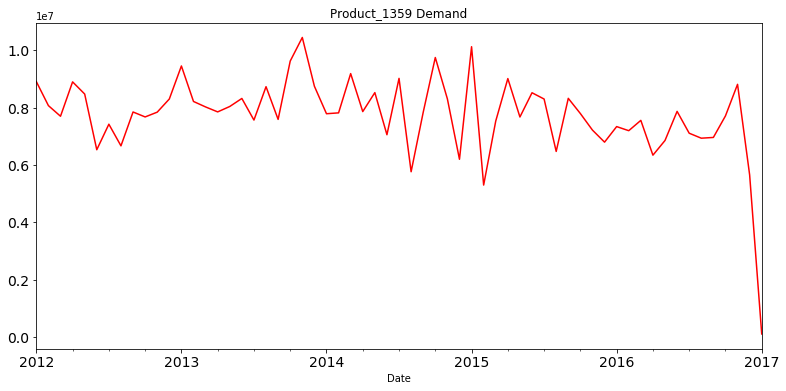

In [16]:
df_demand_md.Order_Demand.plot(figsize=(13,6), title= 'Product_1359 Demand', fontsize=14,color="Red")
plt.show()

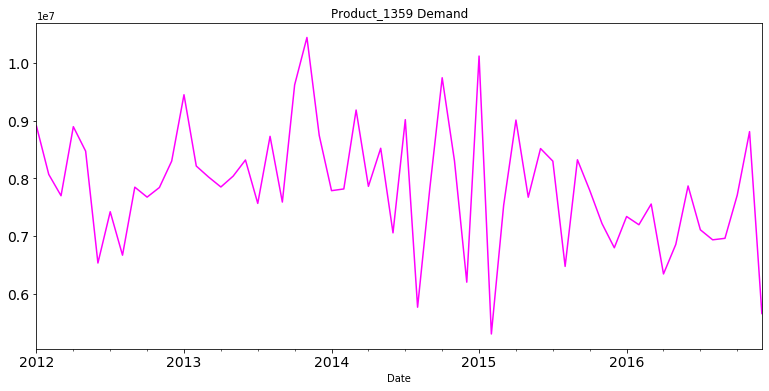

In [17]:
df_demand_md.drop(df_demand_md.loc[df_demand_md['Order_Demand']==100000].index,inplace=True) # dropping the va;ue of the 2017 month
df_demand_md.Order_Demand.plot(figsize=(13,6), title= 'Product_1359 Demand', fontsize=14,color="Magenta")
plt.show()

In [18]:
df_demand_md.head()

,Order_Demand
Date,
2012-01-31,8910000.0
2012-02-29,8071000.0
2012-03-31,7700000.0
2012-04-30,8900000.0
2012-05-31,8475000.0


The plot above shows the product demand distribution and now we will use the data to forecast prodcut demand based on other features.

### Time Series Forecasting

Before applying any statistical model on a time series, we want to ensure it’s stationary. If a time series is stationary and has a particular behaviour over a given time interval, then it is safe to assume that it will have same behaviour at some later point in time. Most statistical modelling methods assume or require the time series to be stationary.

Source : https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [19]:
#Import libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Let’s create a function to run the two tests which determine whether a given time series is stationary.

In [20]:
# rolling statistics

rolling_mean = df_demand_md.rolling(window=30,center=False).mean()
rolling_std = df_demand_md.rolling(window=30,center=False).std()

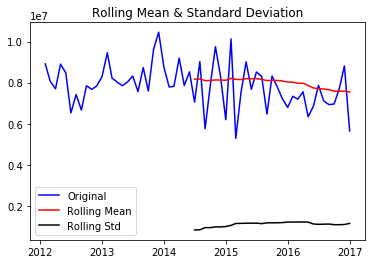

In [21]:
# rolling statistics plot

original = plt.plot(df_demand_md, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

It mostly looks stationary, however we can improve the timeseries data

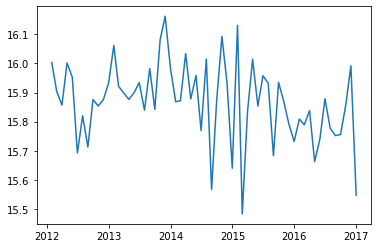

In [22]:
#Estimating Trend

log_Scale = np.log(df_demand_md)
plt.plot(log_Scale)

In [23]:
def get_stationarity(timeseries):
    # Dickey–Fuller test:
    result = adfuller(df_demand_md['Order_Demand'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

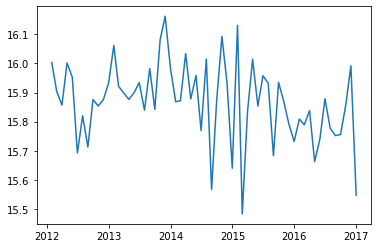

In [24]:
df_demand_md_log=np.log(df_demand_md)
plt.plot(df_demand_md_log)

In [25]:
rolling_mean = df_demand_md_log.rolling(window=12).mean()
df_demand_md_log_minus_mean = df_demand_md_log - rolling_mean
df_demand_md_log_minus_mean.dropna(inplace=True)

get_stationarity(df_demand_md_log_minus_mean)

ADF Statistic: -7.68895171235469
p-value: 1.4363326476691708e-11
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


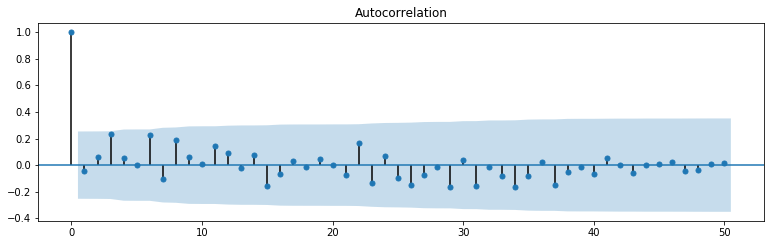

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

demand1 = df_demand_md.values

fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(demand1, lags=50, ax=ax1)

The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with its own lagged versions.

Lets first divide data into train and test and apply ARIMA model. Let see, how it is preforming in our data.

Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [27]:
#spliting the data into test and train
from statsmodels.tsa.arima_model import ARIMA
train = df_demand_md[:'2015-12-31']
test = df_demand_md['2016-01-31':]
train = train.dropna()
test = test.dropna()

                             ARIMA Model Results                              
Dep. Variable:         D.Order_Demand   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -719.656
Method:                       css-mle   S.D. of innovations        1034163.852
Date:                Mon, 12 Oct 2020   AIC                           1447.311
Time:                        23:36:34   BIC                           1454.712
Sample:                    02-29-2012   HQIC                          1450.096
                         - 12-31-2015                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8139.1955   9663.231     -0.842      0.400   -2.71e+04    1.08e+04
ar.L1.D.Order_Demand    -0.1236      0.146     -0.845      0.398      -0.411       0.163
ma.L1.D.Orde

<Figure size 720x720 with 0 Axes>

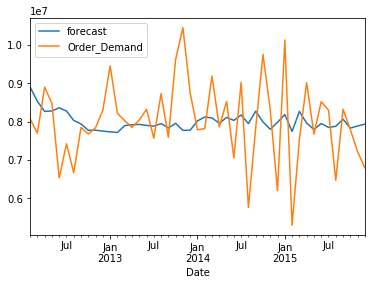

In [28]:
y_hat_avg = test.copy()
model = ARIMA(train, order=(1,1,1))
prediction = model.fit()
print(prediction.summary())

plt.figure(figsize=(10,10))
prediction.plot_predict(dynamic=False)
plt.show()

In [29]:
forecast, se, conf = prediction.forecast(12, alpha=0.09)

In [30]:
# converting to series
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

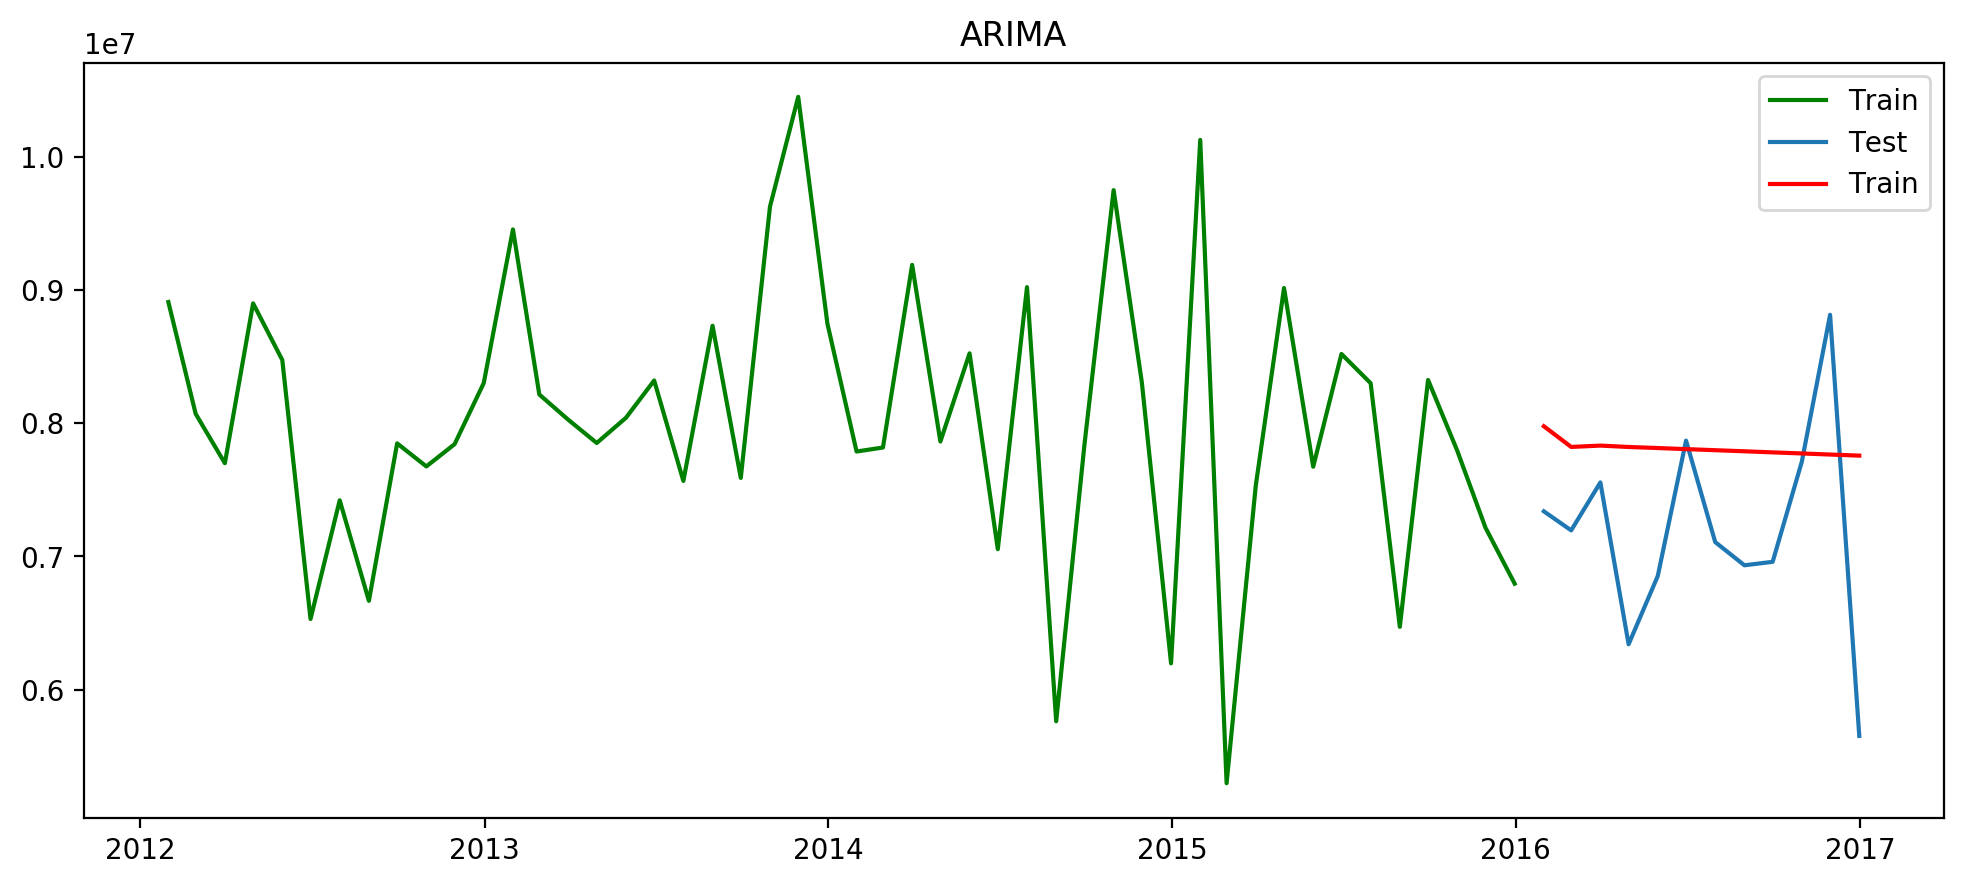

In [31]:
#visualization
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='Train', color="Green")
plt.plot(test, label='Test')
plt.plot(forecast_series, label='Train', color="Red")
plt.title("ARIMA")
plt.legend(loc='best')
plt.show()

ARIMA model doesn't seem to perfom well.

#### 2) Using Simple smoothing technique

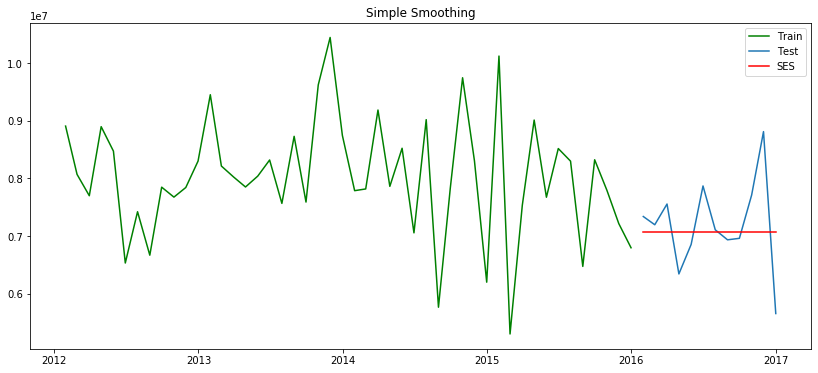

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Order_Demand'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot(train['Order_Demand'], label='Train',color="Green")
plt.plot(test['Order_Demand'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES',color="Red")
plt.title("Simple Smoothing")
plt.legend(loc='best')
plt.show()

In [34]:
import math
from sklearn.metrics import mean_squared_error
smooth_rms = math.sqrt(mean_squared_error(test.Order_Demand, y_hat_avg.SES))
print(smooth_rms)

767132.9159973072


#### 3) Using Exponential smoothing technique

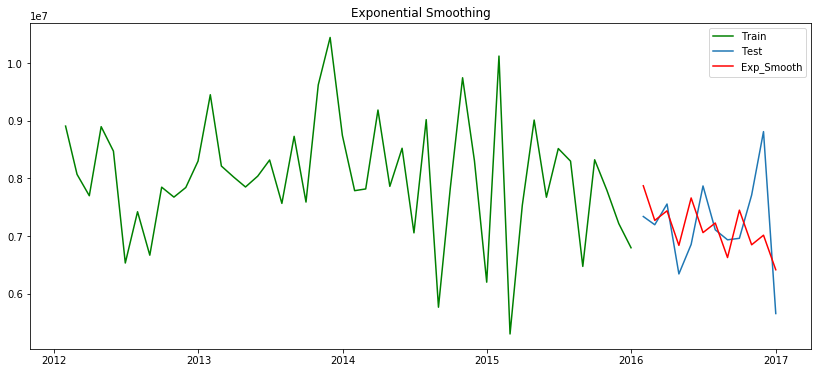

In [37]:
exp_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Order_Demand']) ,seasonal_periods=4 ,trend='additive', seasonal='additive',).fit()
exp_hat_avg['Exp_Smooth'] = fit1.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot(train['Order_Demand'], label='Train',color="Green")
plt.plot(test['Order_Demand'], label='Test')
plt.plot(exp_hat_avg['Exp_Smooth'], label='Exp_Smooth',color="Red")
plt.legend(loc='best')
plt.title("Exponential Smoothing");
plt.show()

In [49]:
import math
from sklearn.metrics import mean_squared_error

exp_rms = math.sqrt(mean_squared_error(test.Order_Demand, exp_hat_avg.Exp_Smooth))
print(exp_rms)

751344.1306033883


#### 4) Using Decomposition technique

In [39]:
decomposition = seasonal_decompose(df_demand_md)

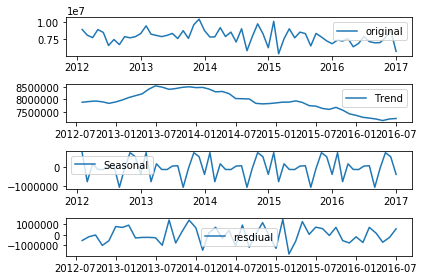

In [42]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_demand_md, label = "original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label = "Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label = "Seasonal")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label = "resdiual")
plt.legend(loc="best")
plt.tight_layout()


decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

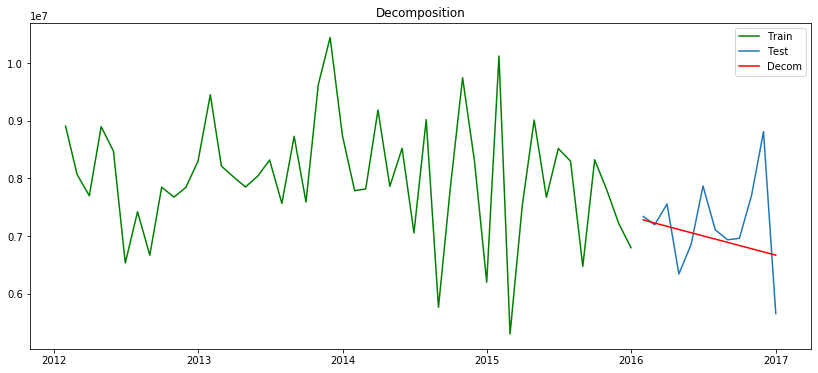

In [43]:
decom_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Order_Demand'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
decom_hat_avg['Decom'] = fit1.forecast(len(test))

plt.figure(figsize=(14,6))
plt.plot(train['Order_Demand'], label='Train',color="Green")
plt.plot(test['Order_Demand'], label='Test')
plt.plot(decom_hat_avg['Decom'], label='Decom',color="Red")
plt.legend(loc='best')
plt.title("Decomposition");
plt.show()

In [44]:
import math
from sklearn.metrics import mean_squared_error

decom_rms = math.sqrt(mean_squared_error(test.Order_Demand, decom_hat_avg.Decom))
print(decom_rms)

809306.5678779637


Now, lets plot mean square error for comparison

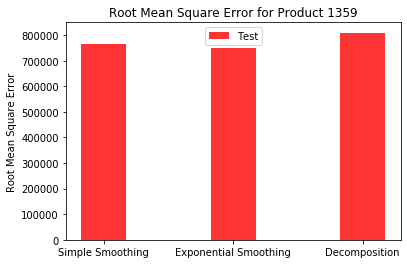

In [59]:
n_groups = 3
test_mse = (smooth_rms,exp_rms,decom_rms)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
 
rects2 = plt.bar(index + bar_width, test_mse, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Test')
 
plt.ylabel('Root Mean Square Error')
plt.title('Root Mean Square Error for Product 1359')
plt.xticks(index + bar_width, ('Simple Smoothing', 'Exponential Smoothing', 'Decomposition'))
plt.legend()

We showed that it is possible, with trivial models, to lower the mean average forecasting error to only around 20% in terms of volume of command. This should prove that there is a predicting potential in this dataset that only waits to be exploited.